#Consume APIs in a Notebook

This notebook uses a Data Source of updates to Wikipedia to show how to consume data from queries using the Query API and from API endpoints using the Pipes API.

For less than 100 MB of data, you can fetch all the data with a call to the query API or from an API endpoint, using parameters if you wish.

When there is a lot of data you can't fetch all the data in one go. You need to query it little by little, with not more than 100 MB per API call.

The solution is to get batches using Data Source sorting keys. Selecting the data by columns used in the sorting key ensures that it is fast.

In this example, the Data Source is sorted on the timestamp column so we use batches of a fixed amount of time. In general, time is a good way to batch. 

The functions ``fetch_table_streaming_query`` and ``fetch_table_streaming_endpoint`` in the notebook work as generators. They should always be used in a for loop or as the input for another generator.

You should process each batch as it arrives and discard unwanted fetched data. Only fetch the data you need in the processing. The idea here is not to recreate a Data Source in the notebook but to process each batch as it arrives and write less data to your DataFrame.



#Create a Data Source of example data from wiki edits

- Download this 120 MB file to your local machine https://storage.googleapis.com/tinybird-assets/datasets/guides/wiki.csv
- Create an empty Data Source in your workspace using the defined scheme, which ensures that the sorting key is 'timestamp'
- Upload the file using Tinybird's UI

In [ ]:
!pip install tinybird-cli -q

     |████████████████████████████████| 84 kB 2.0 MB/s 
     |████████████████████████████████| 61 kB 6.9 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
     |████████████████████████████████| 2.2 MB 59.3 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
def write_text_to_file(filename, text):
  with open(filename, 'w') as f: f.write(text)

In [ ]:
filename = 'wiki.datasource'
text='''
SCHEMA >
    `meta` LowCardinality(String),
    `id` Int64,
    `type` String,
    `namespace` Int16,
    `title` String,
    `comment` Nullable(String),
    `timestamp` Int64,
    `user` String,
    `bot` String,
    `minor` Nullable(String),
    `patrolled` Nullable(String),
    `server_url` LowCardinality(String),
    `server_name` LowCardinality(String),
    `server_script_path` String,
    `wiki` LowCardinality(String),
    `parsedcomment` Nullable(String)

ENGINE "MergeTree"
ENGINE_SORTING_KEY "timestamp"
'''

write_text_to_file(filename, text)

In [ ]:
!tb --token=$token push wiki.datasource

** Processing wiki.datasource
** Building dependencies
** Running wiki 
** 'wiki' created
** Not pushing fixtures


Check the start and end dates of the Data Source.

In [7]:
!tb --token=$token sql "SELECT min(toDateTime(timestamp)) start, max(toDateTime(timestamp)) end from wiki"

---------------------------------------------
| start               | end                 |
---------------------------------------------
| 2022-02-13 10:15:37 | 2022-02-13 13:15:46 |
---------------------------------------------


In [8]:
min_ts=!tb --token=$token sql 'select min(timestamp) from wiki' --format=csv
max_ts=!tb --token=$token sql 'select max(timestamp) from wiki' --format=csv
min_ts[1], max_ts[1]

('1644747337', '1644758146')

#Fetch data with the Query API

In [9]:
import requests 
from urllib.parse import urlencode
import pandas as pd

from io import StringIO

This Data Source contains too much data to import the complete Data Source in a single API call (limit 100 MB).

In [10]:
table_name = 'wiki'
host = 'api.tinybird.co'
format = 'CSVWithNames'

s = requests.Session()
s.headers['Authorization'] = f'Bearer {token}'
URL = f'https://{host}/v0/sql'
sql = f'select * from {table_name}'
params = {'q': sql + f" FORMAT {format}"}

r = s.get(f"{URL}?{urlencode(params)}")
r.text

'{"error": "[Error] Limit for result exceeded, max bytes: 100.00 MiB, current bytes: 100.45 MiB", "documentation": "https://docs.tinybird.co/api-reference/query-api.html#get--v0-sql"}'

With a condition to select less data, a DataFrame can be created from the request using the Query API.

In [13]:
ts = int(max_ts[1]) - 60*60 # one hour less of data
ts

1644754546

In [14]:
table_name = 'wiki'
host = 'api.tinybird.co'
format = 'CSVWithNames'
time_column = 'toDateTime(timestamp)'
date_end = 'toDateTime('+str(ts)+')'

s = requests.Session()
s.headers['Authorization'] = f'Bearer {token}'
URL = f'https://{host}/v0/sql'
sql = f'select * from {table_name} where {time_column} <= {date_end}'
params = {'q': sql + f" FORMAT {format}"}

r = s.get(f"{URL}?{urlencode(params)}")
df = pd.read_csv(StringIO(r.text))

In [15]:
df.head()

,meta,id,type,namespace,title,comment,timestamp,user,bot,minor,patrolled,server_url,server_name,server_script_path,wiki,parsedcomment
0,tr.wikipedia.org,50148330,edit,0,İstanbul,/* Tarihsel nüfus */1927 ve sonrası aşağıdaki ...,1644747337,Vikipedi dostu,False,False,\N,https://tr.wikipedia.org,tr.wikipedia.org,/w,trwiki,"<span dir=""auto""><span class=""autocomment""><a ..."
1,ar.wikipedia.org,264743266,categorize,14,تصنيف:فهرس المجرات الرئيسية,أضيفت [[:NGC 3561]] إلى التصنيف، [[Special:Wha...,1644747338,JarBot,True,\N,\N,https://ar.wikipedia.org,ar.wikipedia.org,/w,arwiki,"أضيفت <a href=""/wiki/NGC_3561"" title=""NGC 3561..."
2,en.wikipedia.org,1474164163,categorize,14,Category:Pages using Infobox writer with unkno...,"[[:Emily Dickinson]] removed from category, [[...",1644747338,Xxanthippe,False,\N,\N,https://en.wikipedia.org,en.wikipedia.org,/w,enwiki,"<a href=""/wiki/Emily_Dickinson"" title=""Emily D..."
3,www.wikidata.org,1626489454,edit,4,Wikidata:Database reports/Constraint violation...,report update for [[Property:P2079]],1644747343,KrBot2,True,False,True,https://www.wikidata.org,www.wikidata.org,/w,wikidatawiki,"report update for <a href=""/wiki/Property:P207..."
4,en.wikipedia.org,1474164155,categorize,14,Category:Sikkim politician stubs,[[:Tashi Tshering (Sikkimese politician)]] add...,1644747344,Curbon7,False,\N,\N,https://en.wikipedia.org,en.wikipedia.org,/w,enwiki,"<a href=""/wiki/Tashi_Tshering_(Sikkimese_polit..."


In [16]:
len(df)

165253

#Fetch data from an API Endpoint with Parameters

Data can be selected by sending parameters to the endpoint.

Endpoint node in the pipe endpoint_wiki
```
%
SELECT * FROM wiki
WHERE timestamp BETWEEN 
toInt64(toDateTime({{String(date_start, '2022-02-13 10:30:00')}}))
AND
toInt64(toDateTime({{String(date_end, '2022-02-13 11:00:00')}}))
```

In [17]:
host = 'api.tinybird.co'
api_endpoint = 'endpoint_wiki'
format = 'csv'

date_start = '2022-02-13 10:30:00'
date_end = '2022-02-13 11:30:00'

s = requests.Session()
s.headers['Authorization'] = f'Bearer {token}'

URL = f'https://{host}/v0/pipes/{api_endpoint}.{format}'
params = {'date_start': date_start,
          'date_end': date_end
          }
          
r = s.get(f"{URL}?{urlencode(params)}")
df = pd.read_csv(StringIO(r.text))

In [18]:
df.head()

,meta,id,type,namespace,title,comment,timestamp,user,bot,minor,patrolled,server_url,server_name,server_script_path,wiki,parsedcomment
0,commons.wikimedia.org,1866432509,categorize,14,Category:Churches in the Roman Catholic Archdi...,[[:Category:Saint Hedwig of Anjou church in Go...,1644751646,Macuk,False,NaN,NaN,https://commons.wikimedia.org,commons.wikimedia.org,/w,commonswiki,"<a href=""/wiki/Category:Saint_Hedwig_of_Anjou_..."
1,commons.wikimedia.org,1866432504,edit,6,"File:Small terracotta figurines, 1400-1300 BC,...",/* wbsetclaim-create:2||1 */ [[d:Special:Entit...,1644751646,Zde,False,False,True,https://commons.wikimedia.org,commons.wikimedia.org,/w,commonswiki,"‎<span dir=""auto""><span class=""autocomment"">Cr..."
2,commons.wikimedia.org,1866432498,categorize,14,Category:1864 books from the United Kingdom,[[:Category:Geological Magazine (1864)]] added...,1644751646,Hornstrandir1,False,NaN,NaN,https://commons.wikimedia.org,commons.wikimedia.org,/w,commonswiki,"<a href=""/wiki/Category:Geological_Magazine_(1..."
3,de.wikipedia.org,317829323,edit,0,Meister Eder und sein Pumuckl,Fehlendes End-TAG ([[Spezial:LintErrors/missin...,1644751646,Crazy1880,False,True,NaN,https://de.wikipedia.org,de.wikipedia.org,/w,dewiki,"Fehlendes End-TAG (<a href=""/wiki/Spezial:Lint..."
4,ja.wikipedia.org,132912954,edit,0,ハーリド・ハウジャ,"修正, replaced: [[シリア騒乱| → [[シリア内戦|",1644751646,Saaki4AWB,False,True,NaN,https://ja.wikipedia.org,ja.wikipedia.org,/w,jawiki,"修正, replaced: [[シリア騒乱| → [[シリア内戦|"


In [19]:
len(df)

84389

# Fetch batches of data using the Query API

When there is a lot of data you can't fetch all the data in one go. You need to query it little by little, with not more than 100 MB per API call.

The solution is to get batches using Data Source sorting keys. Selecting the data by columns used in the sorting key ensures that it is fast.

In this example, the Data Source is sorted on the timestamp column so we use batches of a fixed amount of time. In general, time is a good way to batch. 

The function ``fetch_table_streaming_query`` works as a generator. It should always be used in a for loop or as the input for another generator.

You should process each batch as it arrives and discard unwanted fetched data. Only fetch the data you need in the processing. The idea here is not to recreate a Data Source in the notebook but to process each batch as it arrives and write less data to your final DataFrame.

The batches are of 5 minutes within the defined date range.


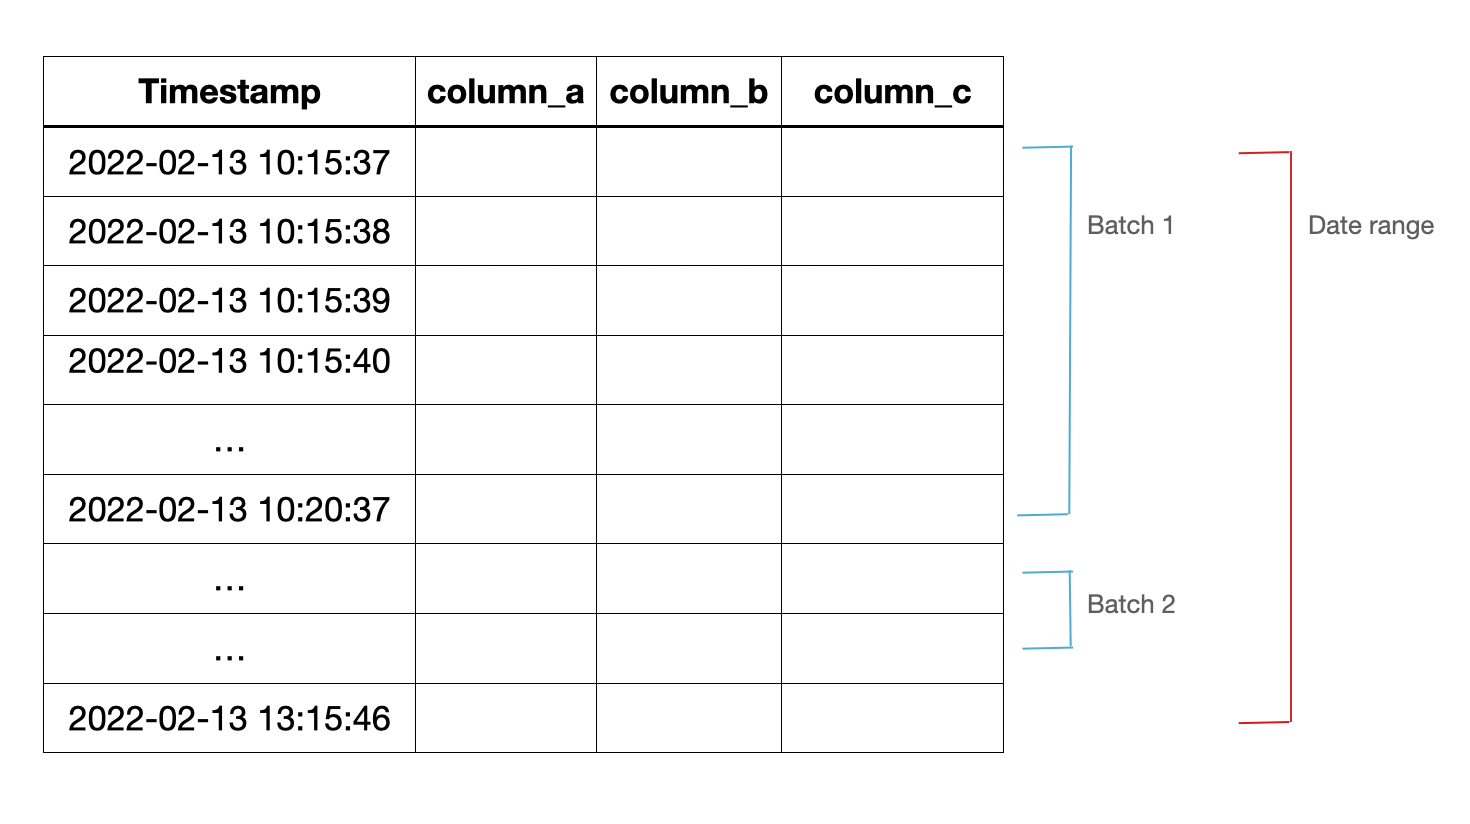

In [20]:
import requests 
from urllib.parse import urlencode
import pandas as pd

from io import StringIO

In [21]:
def fetch_table_streaming_query(token, 
                          table_name, 
                          batch, 
                          date_start, 
                          date_end, 
                          sorting=None, 
                          filters=None, 
                          time_column=None, 
                          host='api.tinybird.co'):
      """
      @token: tinybird token, get it from your account
      @table_name: table you want to fetch data from
      @batch: seconds for each batch
      @date_start: expression for start date
      @date_end: expression for end date
      @sorting: SQL expression to sort the data, like `column0 asc` 
      @filters: SQL filters, i.e `column00 > 10 and column01 = 'blue'`
      @time_column: column name with the timestamp
      @host: tinybird host used
      """
      s = requests.Session()
      s.headers['Authorization'] = f'Bearer {token}'
      URL = f'https://{host}/v0/sql'
      
      def q(SQL, format='JSON'):
          params = {'q': SQL + f" FORMAT {format}"}
          r = s.get(f"{URL}?{urlencode(params)}")
          if r.status_code == 200:
              if format == 'JSON':
                  return r.json()
              else:
                  return r.text
          raise Exception(f'failed to fetch {SQL}: {r.text}')
  
      batch_no = 0
      while True:
          sql = f'select * from {table_name}'
          # The most important part is to retrieve data in batches using an indexed column. 
          # Here batching is done using the "time_column", which is part of the sorting key.
          sql += f"""
              where {time_column} between {date_start} + {batch_no*batch} 
                                  and {date_start} + {(batch_no+1)*batch} 
                                  and {time_column} <= {date_end}
          """
          if filters:
              sql += f" and {filters}"
          if sorting:
              sql += f" order by {sorting}"
          if batch_no == 0:
              print (sql)
          r = q(sql, 'CSVWithNames')

          # drop the header and check if the stream finished
          header_len = len(r.split('\n', 1)[0])
          if len(r[header_len:]) == 1:
              # everything done
              break
          else:
              # fetch a new batch
              yield r
          batch_no += 1

In [22]:
def process_dataframe(df):
  # TO DO: process df and discard fetched data
  return df

In [23]:
%%time

tinybird_stream = fetch_table_streaming_query(token, 
                                        'wiki', 
                                        60*5, 
                                        int(min_ts[1]), 
                                        int(max_ts[1]), 
                                        sorting='timestamp', 
                                        filters="type IN ['edit','new']", 
                                        time_column="timestamp", 
                                        host='api.tinybird.co')

df_all=pd.DataFrame()
for x in tinybird_stream:
    df_batch = pd.read_csv(StringIO(x))
    # TO DO: process batch and discard fetched data 
    df_proc=process_dataframe(df_batch)
    df_all = df_all.append(df_proc) # Careful: appending dfs means keeping a lot of data in memory

select * from wiki
              where timestamp between 1644747337 + 0 
                                  and 1644747337 + 300 
                                  and timestamp <= 1644758146
           and type IN ['edit','new'] order by timestamp
CPU times: user 3.07 s, sys: 126 ms, total: 3.19 s
Wall time: 10.4 s


In [24]:
df_batch.head()

,meta,id,type,namespace,title,comment,timestamp,user,bot,minor,patrolled,server_url,server_name,server_script_path,wiki,parsedcomment
0,www.wikidata.org,1626545210,edit,0,Q7619083,/* wbsetclaim-update:2||1|2 */ [[Property:P186...,1644758137,Damian Vo,False,False,True,https://www.wikidata.org,www.wikidata.org,/w,wikidatawiki,"‎<span dir=""auto""><span class=""autocomment"">Đã..."
1,www.wikidata.org,1626545212,edit,0,Q60838546,/* wbsetclaim-create:2||1 */ [[Property:P106]]...,1644758137,Gerarus,False,False,True,https://www.wikidata.org,www.wikidata.org,/w,wikidatawiki,"‎<span dir=""auto""><span class=""autocomment"">Со..."
2,www.wikidata.org,1626545213,edit,0,Q2598950,/* wbeditentity-update-languages-short:0||pt-b...,1644758137,Emijrpbot,True,False,True,https://www.wikidata.org,www.wikidata.org,/w,wikidatawiki,"‎<span dir=""auto""><span class=""autocomment"">Ch..."
3,www.wikidata.org,1626545207,edit,0,Q88184220,"/* wbeditentity-update-languages-short:0||oc, ...",1644758137,Emijrpbot,True,False,True,https://www.wikidata.org,www.wikidata.org,/w,wikidatawiki,"‎<span dir=""auto""><span class=""autocomment"">Ch..."
4,www.wikidata.org,1626545209,edit,0,Q55543064,/* wbsetclaimvalue:1| */ [[Property:P31]]: [[Q...,1644758137,KrBot,True,False,True,https://www.wikidata.org,www.wikidata.org,/w,wikidatawiki,"‎<span dir=""auto""><span class=""autocomment"">Оп..."


In [25]:
df_all.head()

,meta,id,type,namespace,title,comment,timestamp,user,bot,minor,patrolled,server_url,server_name,server_script_path,wiki,parsedcomment
0,tr.wikipedia.org,50148330,edit,0,İstanbul,/* Tarihsel nüfus */1927 ve sonrası aşağıdaki ...,1644747337,Vikipedi dostu,False,False,\N,https://tr.wikipedia.org,tr.wikipedia.org,/w,trwiki,"<span dir=""auto""><span class=""autocomment""><a ..."
1,www.wikidata.org,1626489454,edit,4,Wikidata:Database reports/Constraint violation...,report update for [[Property:P2079]],1644747343,KrBot2,True,False,True,https://www.wikidata.org,www.wikidata.org,/w,wikidatawiki,"report update for <a href=""/wiki/Property:P207..."
2,zh.wikipedia.org,143625480,edit,0,陳沛妍,补救1个来源，并将0个来源标记为失效。) #IABot (v2.0.8.6,1644747345,InternetArchiveBot,True,False,\N,https://zh.wikipedia.org,zh.wikipedia.org,/w,zhwiki,补救1个来源，并将0个来源标记为失效。) #IABot (v2.0.8.6
3,zh.wikipedia.org,143625481,edit,4,Wikipedia:修订版本删除请求,\N,1644747346,Poem,False,False,\N,https://zh.wikipedia.org,zh.wikipedia.org,/w,zhwiki,\N
4,zh.wikipedia.org,143625482,edit,0,水城奈緒,\N,1644747346,滑稽金苹果,False,True,\N,https://zh.wikipedia.org,zh.wikipedia.org,/w,zhwiki,\N


In [26]:
len(df_batch), len(df_all)

(144, 162665)

In [27]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162665 entries, 0 to 143
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   meta                162665 non-null  object
 1   id                  162665 non-null  int64 
 2   type                162665 non-null  object
 3   namespace           162665 non-null  int64 
 4   title               162665 non-null  object
 5   comment             145915 non-null  object
 6   timestamp           162665 non-null  int64 
 7   user                162665 non-null  object
 8   bot                 162665 non-null  bool  
 9   minor               162665 non-null  bool  
 10  patrolled           100794 non-null  object
 11  server_url          162665 non-null  object
 12  server_name         162665 non-null  object
 13  server_script_path  162665 non-null  object
 14  wiki                162665 non-null  object
 15  parsedcomment       145915 non-null  object
dtypes: bo

# Fetch batches of data from an API Endpoint with Parameters

```
%
SELECT * from wiki
--DATE RANGE
WHERE timestamp BETWEEN toUInt64(toDateTime({{String(date_start, '2022-02-13 10:30:00', description="start")}})) 
AND toUInt64(toDateTime({{String(date_end, '2022-02-13 10:35:00', description="end")}}))
--BATCH BEGIN
AND timestamp BETWEEN toUInt64(toDateTime({{String(date_start, '2022-02-13 10:30:00', description="start")}}) 
               + interval {{Int16(batch_no, 1, description="batch number")}} 
               * {{Int16(batch_size, 10, description="size of the batch")}} second)
--BATCH END
AND toUInt64(toDateTime({{String(date_start, '2022-02-13 10:30:00', description="start")}}) 
               + interval ({{Int16(batch_no, 1, description="batch number")}} + 1) 
               * {{Int16(batch_size, 10, description="size of the batch")}} second)
--FILTERS
{% if defined(bot) %}
  AND bot = {{String(bot, description="is a bot")}}
{% end %}
{% if defined(server_name) %}
  AND server_name = {{String(server_name, description="server")}}
{% end %}
```

In [28]:
import requests 
from urllib.parse import urlencode

import pandas as pd
from io import StringIO

In [29]:
def fetch_table_streaming_endpoint(token, 
                                   format, 
                                   batch_size, 
                                   date_start, 
                                   date_end, 
                                   bot=None, 
                                   server_name=None, 
                                   host='api.tinybird.co'):
      """
      @token: tinybird token, get it from your account
      @batch: seconds for each batch (the batch size) (endpoint parameter)
      @date_start:  expression for starting date (endpoint parameter)
      @date_end: expresion for ending date (endpoint parameter)
      @bot: value for bot filter (endpoint paramter)
      @server_name: value for the server_name (endpoint parameter)
      @host: tinybird host used
      """
      
      s = requests.Session()
      s.headers['Authorization'] = f'Bearer {token}'

      api_endpoint = 'wiki_stream_example'  
      URL = f'https://{host}/v0/pipes/{api_endpoint}.{format}'
      params = {
        'batch_size': batch_size,
        'date_start': date_start,
        'date_end': date_end
      }
      
      if bot != None:
        params['bot'] = bot
      if server_name != None:
        params['server_name'] = server_name

      # Define the call to the endpoint with the required parameters
      def call_endpoint(batch_no):
        """
        @batch_no: The id of the batch to iterate through the data
        """

        params['batch_no'] = batch_no

        r = s.get(f"{URL}?{urlencode(params)}")
        
        if r.status_code == 200:
            if format == 'json':
                return r.json()
            else:
                return r.text
        raise Exception(f'failed to fetch {URL}?{urlencode(params)}: {r.text}')

  
      batch_no = 0
      while True:

          r = call_endpoint(batch_no)

          # drop the header and check if the stream finished
          header_len = len(r.split('\n', 1)[0])
          if len(r[header_len:]) == 1:
              # everything done
              break
          else:
              # TODO: at this point a new batch could be fetched
              yield r
          batch_no += 1

In [30]:
def process_dataframe(df):
  # TO DO: process df and discard fetched data
  return df

In [31]:
# fetch in batches of n seconds (make it small to be fast)
tinybird_stream = fetch_table_streaming_endpoint(token,
                                                 'csv',
                                                 60*5, 
                                                 '2022-02-13 10:15:00',
                                                 '2022-02-13 13:15:00',
                                                 bot = False,
                                                 server_name='en.wikipedia.org'
                                                )

df_all=pd.DataFrame()
for x in tinybird_stream:
    df_batch = pd.read_csv(StringIO(x))
    # TO DO: process batch and discard fetched data 
    df_proc=process_dataframe(df_batch)
    df_all = df_all.append(df_proc) # Careful: appending dfs means keeping a lot of data in memory

In [32]:
df_all.head()

,meta,id,type,namespace,title,comment,timestamp,user,bot,minor,patrolled,server_url,server_name,server_script_path,wiki,parsedcomment
0,en.wikipedia.org,1474164163,categorize,14,Category:Pages using Infobox writer with unkno...,"[[:Emily Dickinson]] removed from category, [[...",1644747338,Xxanthippe,False,\N,\N,https://en.wikipedia.org,en.wikipedia.org,/w,enwiki,"<a href=""/wiki/Emily_Dickinson"" title=""Emily D..."
1,en.wikipedia.org,1474164155,categorize,14,Category:Sikkim politician stubs,[[:Tashi Tshering (Sikkimese politician)]] add...,1644747344,Curbon7,False,\N,\N,https://en.wikipedia.org,en.wikipedia.org,/w,enwiki,"<a href=""/wiki/Tashi_Tshering_(Sikkimese_polit..."
2,en.wikipedia.org,1474164154,categorize,14,Category:All stub articles,[[:Tashi Tshering (Sikkimese politician)]] add...,1644747344,Curbon7,False,\N,\N,https://en.wikipedia.org,en.wikipedia.org,/w,enwiki,"<a href=""/wiki/Tashi_Tshering_(Sikkimese_polit..."
3,en.wikipedia.org,1474164161,edit,0,William G. Batchelder,/* Early life and legal career */,1644747348,All Hallow's Wraith,False,True,\N,https://en.wikipedia.org,en.wikipedia.org,/w,enwiki,"<span dir=""auto""><span class=""autocomment""><a ..."
4,en.wikipedia.org,1474164164,edit,0,Opinion polling for the 2022 Philippine presid...,Restored revision 1071581994 by [[Special:Cont...,1644747348,Howard the Duck,False,False,\N,https://en.wikipedia.org,en.wikipedia.org,/w,enwiki,"Restored revision 1071581994 by <a href=""/wiki..."


In [33]:
len(df_batch), len(df_all)

(1, 26027)